In [1]:
# Training variables
rolling_mean = 90
lag = 8
# Only use time-series features

## Import data from AWS S3

In [2]:
import sys
sys.path.insert(0, '/home/khiem/Dropbox/Education/Drexel/DSCI-591/Project/Walmart-Strategic-Sales-Forecasting')

In [3]:
import boto3
import pandas as pd

bucket = 'dsci-632'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket="dsci-632", Key="CA_1_sales_data.csv")
df = pd.read_csv(obj['Body'], index_col=0, parse_dates=True) # 'Body' is a keyword
print(df.head())

            wm_yr_wk  wday  month  year event_name_1 event_type_1  \
2011-01-29     11101     1      1  2011         None         None   
2011-01-30     11101     2      1  2011         None         None   
2011-01-31     11101     3      1  2011         None         None   
2011-02-01     11101     4      2  2011         None         None   
2011-02-02     11101     5      2  2011         None         None   

           event_name_2 event_type_2      cpi  unemployment_rate  gas_price  \
2011-01-29         None         None  221.187                9.1      3.163   
2011-01-30         None         None  221.187                9.1      3.163   
2011-01-31         None         None  221.187                9.1      3.155   
2011-02-01         None         None  221.898                9.0      3.155   
2011-02-02         None         None  221.898                9.0      3.155   

            snap_ca  ca_walmart  ca_hobbies  ca_household  ca_foods  \
2011-01-29        0       39.50       2

## Data Processing

In [4]:
from data_processing.pre_modeling import pre_modeling

df_processed = pre_modeling(df)

## Data Analysis

In [5]:
timeseries_cols = ['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price']
time_cols = ['wm_yr_wk', 'wday', 'day', 'month', 'year']
target_col = ['store_sales']
cat_cols = [col for col in df_processed.columns if col not in timeseries_cols + time_cols + target_col] # extract the remaining columns

In [6]:
df_used = df_processed[timeseries_cols+target_col]
df_used = df_used.rolling(rolling_mean).mean().dropna()

In [7]:
nobs = 30
df_original = df_used
df_test = df_used[-nobs:]
df_train = df_used[0:-nobs]

print(df_train.columns)

Index(['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies',
       'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price',
       'store_sales'],
      dtype='object')


In [8]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value > sig:
        return True
    else:
        return False

def adfuller_test_all(df, sig=0.05):
    non_stationary = []
    stationary = []
    for name, column in df_train.iteritems():
        if adfuller_test(column, name=column.name):
            non_stationary.append(column.name)
        else:
            stationary.append(column.name)

    print('Non-stationary:', non_stationary)
    print('Stationary:', stationary)

adfuller_test_all(df_train)

Non-stationary: ['cpi', 'unemployment_rate', 'gas_price', 'median_price', 'max_price', 'store_sales']
Stationary: ['ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'min_price']


In [9]:
df_train = df_train.diff().dropna()
adfuller_test_all(df_train)

Non-stationary: []
Stationary: ['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price', 'store_sales']


In [10]:
from statsmodels.tsa.api import VAR

df_train_fit = df_train[timeseries_cols+target_col]
model = VAR(df_train_fit)
x = model.select_order(maxlags=12)
x.summary()

/home/khiem/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-84.55,-84.52,1.906e-37,-84.54
1,-108.2,-107.8*,1.060e-47,-108.0
2,-108.5,-107.7,7.562e-48,-108.2
3,-108.6,-107.4,6.969e-48,-108.2
4,-108.7,-107.2,6.394e-48,-108.1
5,-108.7,-106.8,6.088e-48,-108.0
6,-109.0,-106.7,4.780e-48,-108.1
7,-109.3,-106.6,3.552e-48,-108.3
8,-109.9*,-107.0,1.800e-48*,-108.8*
9,-109.9,-106.6,1.866e-48,-108.7


In [11]:
model_fitted = model.fit(lag)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 08, Aug, 2022
Time:                     01:00:25
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -106.977
Nobs:                     1813.00    HQIC:                  -108.852
Log likelihood:           72349.7    FPE:                1.77909e-48
AIC:                     -109.949    Det(Omega_mle):     1.05017e-48
--------------------------------------------------------------------
Results for equation cpi
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.000342         0.000087            3.931           0.000
L1.cpi                       0.938940         0.025054           37.476           0.000
L1.unemployment_rate         0.040

In [12]:
print(model_fitted.params["store_sales"][["const", 
                                          "L1.ca_walmart", "L1.ca_household", "L1.ca_foods", "L1.max_price", "L1.store_sales", 
                                          "L2.gas_price", "L2.ca_walmart", "L2.ca_foods", "L2.store_sales", 
                                          "L3.cpi", "L3.ca_walmart", 
                                          "L5.ca_walmart", "L5.min_price", "L5.store_sales", 
                                          "L6.ca_walmart", "L6.store_sales", "L7.ca_walmart", "L7.ca_hobbies", "L7.ca_foods", "L7.store_sales"]])

const                 1.318952
L1.ca_walmart         6.152138
L1.ca_household       2.476919
L1.ca_foods          -4.422695
L1.max_price        176.643230
L1.store_sales        0.290330
L2.gas_price       1358.218883
L2.ca_walmart       -13.752215
L2.ca_foods           8.197350
L2.store_sales       -0.108159
L3.cpi             -283.847806
L3.ca_walmart         6.918438
L5.ca_walmart        -6.581272
L5.min_price      -6565.042792
L5.store_sales       -0.089698
L6.ca_walmart        10.542499
L6.store_sales        0.114931
L7.ca_walmart        14.379993
L7.ca_hobbies         3.912049
L7.ca_foods          -8.701814
L7.store_sales        0.450400
Name: store_sales, dtype: float64


In [13]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_train_fit.values[-lag_order:]
forecast_input

8


array([[ 1.48888889e-02,  3.33333333e-03,  7.66666667e-04,
        -5.10000000e-02,  1.92888889e-01,  2.52000000e-01,
         1.86000000e-01,  4.44089210e-16,  3.33333333e-04,
         1.11111111e-04, -1.95888889e+01],
       [ 1.48888889e-02,  3.33333333e-03,  7.66666667e-04,
         5.26666667e-02,  4.35555556e-02,  2.37000000e-01,
         1.74000000e-01, -4.44089210e-16,  3.33333333e-04,
         1.11111111e-04,  1.66666667e-01],
       [ 1.48888889e-02,  3.33333333e-03,  1.67777778e-03,
         1.22666667e-01, -7.24444444e-02,  5.56666667e-02,
         1.54666667e-01,  0.00000000e+00,  3.33333333e-04,
         1.11111111e-04,  1.63333333e+01],
       [ 1.48888889e-02,  3.33333333e-03,  2.42222222e-03,
         6.63333333e-02,  1.86666667e-02,  1.15222222e-01,
         2.51111111e-01,  4.44089210e-16,  3.33333333e-04,
         1.11111111e-04,  1.46555556e+01],
       [ 1.48888889e-02,  3.33333333e-03,  2.42222222e-03,
         8.36666667e-02, -8.88888889e-03, -1.70000000e-01,
  

In [14]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_original.index[-nobs:], columns=df_train_fit.columns + '_1d')
df_forecast["store_sales_1d"]

2016-04-23    -3.496527
2016-04-24    11.371613
2016-04-25     8.968208
2016-04-26     3.177751
2016-04-27     3.937521
2016-04-28    -1.856926
2016-04-29   -10.972341
2016-04-30    -2.026209
2016-05-01     9.555466
2016-05-02     7.380362
2016-05-03     3.917698
2016-05-04     4.332737
2016-05-05    -1.778297
2016-05-06    -8.392756
2016-05-07    -1.360054
2016-05-08     7.657521
2016-05-09     6.551685
2016-05-10     4.170598
2016-05-11     4.164889
2016-05-12    -1.469976
2016-05-13    -6.460957
2016-05-14    -0.826225
2016-05-15     6.282364
2016-05-16     5.779358
2016-05-17     4.231429
2016-05-18     3.861946
2016-05-19    -1.104748
2016-05-20    -4.965969
2016-05-21    -0.510368
2016-05-22     5.088528
Name: store_sales_1d, dtype: float64

In [15]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(df_original[0:-nobs][timeseries_cols+target_col], df_forecast)        
df_results.head(10)

,cpi_1d,unemployment_rate_1d,gas_price_1d,ca_walmart_1d,ca_hobbies_1d,ca_household_1d,ca_foods_1d,median_price_1d,min_price_1d,max_price_1d,...,unemployment_rate_forecast,gas_price_forecast,ca_walmart_forecast,ca_hobbies_forecast,ca_household_forecast,ca_foods_forecast,median_price_forecast,min_price_forecast,max_price_forecast,store_sales_forecast
2016-04-23,0.015223,0.003110,0.002341,0.094891,0.027491,-0.002735,0.186185,-4.828142e-07,0.000291,0.000289,...,4.977554,2.013275,25.004224,27.257602,39.418043,52.356296,3.480000,0.214291,29.970289,4421.036806
2016-04-24,0.015800,0.002951,0.002830,0.132037,0.072884,-0.060825,0.176712,5.942608e-06,0.000274,0.000586,...,4.980505,2.016104,25.136262,27.330486,39.357217,52.533008,3.480005,0.214564,29.970875,4432.408420
2016-04-25,0.016687,0.002844,0.003241,0.085709,0.040407,-0.067383,0.161793,2.282860e-06,0.000240,0.001307,...,4.983349,2.019345,25.221971,27.370893,39.289835,52.694802,3.480008,0.214805,29.972182,4441.376628
2016-04-26,0.016865,0.002739,0.003188,0.062820,0.035239,-0.028338,0.147984,1.375247e-05,0.000214,0.001762,...,4.986089,2.022533,25.284791,27.406132,39.261497,52.842786,3.480021,0.215019,29.973943,4444.554379
2016-04-27,0.017432,0.002596,0.003164,0.075652,0.041768,-0.030758,0.163906,1.576192e-05,0.000227,0.001941,...,4.988685,2.025697,25.360443,27.447900,39.230738,53.006692,3.480037,0.215246,29.975885,4448.491900
2016-04-28,0.017590,0.002514,0.003177,0.061032,0.038603,-0.029321,0.187818,1.428567e-05,0.000227,0.002118,...,4.991199,2.028874,25.421475,27.486503,39.201418,53.194510,3.480052,0.215473,29.978003,4446.634974
2016-04-29,0.018077,0.002423,0.003139,0.015010,0.002369,0.013241,0.171038,1.746636e-05,0.000218,0.001727,...,4.993622,2.032013,25.436486,27.488872,39.214658,53.365547,3.480069,0.215691,29.979730,4435.662633
2016-04-30,0.018227,0.002299,0.003074,0.062863,0.013230,-0.033820,0.148596,1.522965e-05,0.000211,0.001803,...,4.995921,2.035087,25.499349,27.502102,39.180839,53.514144,3.480084,0.215902,29.981532,4433.636423
2016-05-01,0.018594,0.002198,0.003359,0.107106,0.043829,-0.082454,0.139386,1.747530e-05,0.000205,0.002149,...,4.998119,2.038446,25.606455,27.545931,39.098384,53.653530,3.480102,0.216108,29.983682,4443.191889
2016-05-02,0.018888,0.002098,0.003602,0.086356,0.033667,-0.065088,0.137102,1.758331e-05,0.000215,0.002486,...,5.000217,2.042048,25.692812,27.579598,39.033296,53.790633,3.480119,0.216323,29.986167,4450.572252


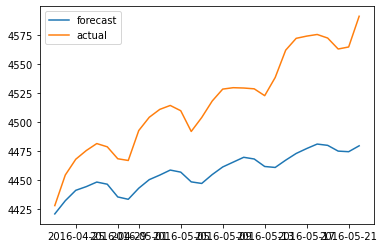

In [16]:
import matplotlib.pyplot as plt

plt.plot(df_results.index, df_results["store_sales_forecast"], label = "forecast")
plt.plot(df_test.index, df_test["store_sales"], label = "actual")
plt.legend()
plt.show()


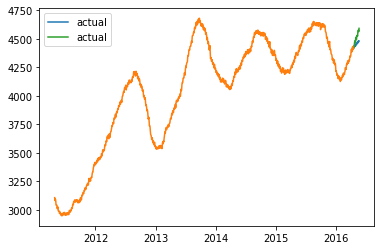

In [17]:
plt.plot(df_results["store_sales_forecast"].index, df_results["store_sales_forecast"], label = "actual")
plt.plot(df_original["store_sales"][0:-nobs].index, df_original["store_sales"][0:-nobs])
plt.plot(df_test.index, df_test["store_sales"], label = "actual")
plt.legend()
plt.show()

In [18]:
# evaluate the model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import numpy as np

error_mse = mean_squared_error(df_test["store_sales"], df_results["store_sales_forecast"])
error_rmse = np.sqrt(error_mse)
error_r2 = r2_score(df_test["store_sales"], df_results["store_sales_forecast"])
error_wape = ((df_results["store_sales_forecast"] - df_test["store_sales"]) / df_test["store_sales"]).mean() 
error_wmape = np.mean(np.abs(df_test["store_sales"] - df_results["store_sales_forecast"]) / df_test["store_sales"])
print("MSE:", error_mse)
print("RMSE:", error_rmse)
print("R2:", error_r2)
print("WAPE:", error_wape)
print("WMAPE:", error_wmape)


MSE: 4326.205713281004
RMSE: 65.77389841936545
R2: -1.544619896537311
WAPE: -0.013296707158368583
WMAPE: 0.013296707158368583
